# Image Captioning - Team SaaS

### Imports here

In [51]:
# python2 and python3 compatibility between loaded modules
from __future__ import print_function

In [52]:
# All imports go here
%matplotlib notebook

# Reading files
import os

# Vector manipulations
import numpy as np

# DL framework
# torch
import torch
from torch import nn
from torch.nn import functional as F
import torch.utils.data as td
import torchvision as tv
from torch.nn.utils.rnn import pack_padded_sequence

# Plotting images
from matplotlib import pyplot as plt

# COCO loading captions
from pycocotools.coco import COCO
import skimage.io as io
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

# import created vocabulary
from vocab_creator import VocabCreate as vc

# PIL Image
from PIL import Image

# regex for captions
import re

# import nntools
import nntools_modified as nt

# import add for fast addition between lists
from operator import add

from pycocoevalcap.bleu.bleu import Bleu

# json for dumping stuff onto files as output
import json
from json import encoder
encoder.FLOAT_REPR = lambda o: format(o, '.3f')

In [53]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


### Data Loading Initializations

In [54]:
# data loading
dataset_root_dir = '/datasets/COCO-2015/'
annotations_root_dir = '../datasets/COCO/annotations/'
train_dir = "train2014"
val_dir = "val2014"
test_dir = "test2015"

# output directory for training checkpoints
# This changes for every experiment
op_dir = "../outputs/" + "vgg16_adam"

In [55]:
# training data annotations
train_ann = "{}captions_{}.json".format(annotations_root_dir, train_dir)
coco_train_caps = COCO(train_ann)

loading annotations into memory...
Done (t=0.91s)
creating index...
index created!


### Dataset Loading

In [56]:
# dataset class
class COCODataset(td.Dataset):
    """Class to load the COCODataset"""
    
    def __init__(self, dataset_root_dir, annotations_root_dir, vocab, mode="train2014", image_size=(224, 224)):
        super(COCODataset, self).__init__()
        self.dataset_root_dir = dataset_root_dir
        self.annotations_root_dir = annotations_root_dir
        self.image_size = image_size
        self.mode = mode
        # training data annotations
        self.ann = "{}captions_{}.json".format(annotations_root_dir, mode)
        self.coco_caps = COCO(self.ann)
        # get all the image IDs
        self.image_ids = self.coco_caps.getImgIds()
        self.ann_ids = list(self.coco_caps.anns.keys())
        # loadImgs() returns all the images
        self.imgs = self.coco_caps.loadImgs(self.image_ids)
        self.vocab = vocab
        
    def __len__(self):
        return len(self.ann_ids)
    
    def __repr__(self):
        return "COCODataset(mode={}, image_size={})". \
        format(self.mode, self.image_size)
    
    def __getitem__(self, idx):
        ann_id = self.ann_ids[idx]
        cap = self.coco_caps.anns[ann_id]["caption"]
        img_id = self.coco_caps.anns[ann_id]["image_id"]
        img_path = self.coco_caps.loadImgs(img_id)[0]["file_name"]
        
        img = Image.open('{}/{}/{}'.format(self.dataset_root_dir, self.mode, img_path))
        img = img.convert('RGB')
        transform = tv.transforms.Compose([
            tv.transforms.Resize(self.image_size),
            #tv.transforms.RandomHorizontalFlip(),
            tv.transforms.ToTensor(),
            tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        x = transform(img)
        
        # return caption
        cap = str(cap)
        clean_cap = re.sub(r'[^a-zA-Z0-9 ]+', '', cap)
        word_list = clean_cap.lower().strip().split()
        for i in range(len(word_list)):
            if word_list[i] not in vocab.one_hot_inds:
                word_list[i]="unk_vec"
        d = torch.Tensor([vocab.one_hot_inds["start_vec"]]
                               + [vocab.one_hot_inds[w] for w in word_list]
                               + [vocab.one_hot_inds["end_vec"]]
        )
        return x, d
    

In [57]:
# load the vocabulary
# or Create and save to output
dict_path = "../outputs/vocab.npz"
vocab = vc(train_ann, dict_path)

In [58]:
# create an instance of the cocodataset
training_dataset = COCODataset(dataset_root_dir, annotations_root_dir, vocab)

loading annotations into memory...
Done (t=0.56s)
creating index...
index created!


In [59]:
def myimshow(image, ax=plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image<0] = 0
    image[image>1] = 1
    h = ax.imshow(image)
    ax.axis('off')
    return h

In [60]:
# defining the dataloader to be used
# collate_fn - to pad all the vectors to the same length
def collate_function(data):
    data.sort(key=lambda x:len(x[1]), reverse=True)
    img, cap=zip(*data)

    #stack images
    img = torch.stack(img, 0)

    #concatenate all captions
    cap_lens = [len(c) for c in cap]
    max_cap_lens = max(cap_lens)
    cap_lens = torch.Tensor(cap_lens)

    #pad all captions to max caption length
    padded_caption = torch.zeros(len(cap),max_cap_lens).long()
    for i, c in enumerate(cap):
        c_len = int(cap_lens[i].item())
        padded_caption[i,:c_len] = c[:c_len]

    return img, padded_caption, cap_lens

In [61]:
train_loader = td.DataLoader(training_dataset, batch_size=128, shuffle=True, pin_memory=True,
                             collate_fn=collate_function, worker_init_fn=torch.manual_seed(7))

In [62]:
# index to caption
def index_to_cap(labs):
    """Index to caption"""
    cap = labs.cpu().data.numpy().astype(int)
    caps = [vocab.dict[cap[c]] for c in range(len(cap))]
    #caps = caps[1:-1]
    caps = list(filter(lambda a: a != "start_vec", caps))
    caps = list(filter(lambda a: a != "end_vec", caps))
    caption = " ".join(caps)
    return caption

In [63]:
# validation dataset
val_dataset = COCODataset(dataset_root_dir, annotations_root_dir, vocab, mode=val_dir)

loading annotations into memory...
Done (t=0.30s)
creating index...
index created!


In [64]:
val_loader = td.DataLoader(val_dataset, batch_size=128, shuffle=False, pin_memory=True, collate_fn=collate_function)

In [65]:
# NN classifier from nntools
class NNClassifier(nt.NeuralNetwork):
    
    def __init__(self):
        super(NNClassifier, self).__init__()
        self.cross_entropy = nn.CrossEntropyLoss()
        
    def criterion(self, y, d):
        return self.cross_entropy(y, d)

In [66]:
class CNN_RNN(NNClassifier):
    
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1,
                 num_classes=512, fine_tuning=False):
        super(CNN_RNN, self).__init__()
        vgg = tv.models.vgg16_bn(pretrained=True)
        for param in vgg.parameters():
            param.requires_grad = fine_tuning
        self.features = vgg.features
        # the average pooling is the same
        self.avgpool = vgg.avgpool
        # the classifier is also the same
        self.classifier = vgg.classifier
        # CODE to change the final classifier layer
        num_ftrs = vgg.classifier[6].in_features
        self.classifier[6] = nn.Linear(num_ftrs, num_classes)
        
        # RNN Part
        self.embeddings = nn.Embedding(vocab_size, embed_size)
        self.unit = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, x, caps, lens):
        # COMPLETE the forward prop
        f = self.features(x)
        f = self.avgpool(f)
        f = torch.flatten(f, 1)
        f = self.classifier(f)
        
        # RNN forward prop
        embeddings = self.embeddings(caps)
        inputs = torch.cat((f.unsqueeze(1), embeddings), 1)
        packed_ip = pack_padded_sequence(inputs, lens, batch_first=True)
        
        h_state, _ = self.unit(packed_ip)
        outputs = self.linear(h_state[0])
        return outputs
    
    def greedy_sample(self, feats, max_len=30):
        output_ids = []
        states = None
        inputs = feats.unsqueeze(1)

        for i in range(max_len):
            
            h_state, states = self.unit(inputs, states)
            outputs = self.linear(h_state.squeeze(1))
            predicted = outputs.max(1)[1]
            output_ids.append(predicted)
            inputs = self.embeddings(predicted)
            inputs = inputs.unsqueeze(1)
            
        output_ids = torch.stack(output_ids, 1)
        return output_ids.squeeze()

In [67]:
class CaptionStatsManager(nt.StatsManager):
    
    def __init__(self):
        super(CaptionStatsManager, self).__init__()
        
    def init(self):
        super(CaptionStatsManager, self).init()
        self.tokenized_true = {}
        self.tokenized_pred = {}
        self.scorer = Bleu(4)
        self.running_bleu_scores = [0 for _ in range(4)]
        
    def accumulate(self, loss, x, y, d):
        super(CaptionStatsManager, self).accumulate(loss, x, y, d)        
        self.tokenized_true[0] = []
        self.tokenized_pred[0] = []
        _, pred_cap_lab = torch.max(y, 1)
        true_cap_lab = d
        pred_cap = index_to_cap(pred_cap_lab)
        true_cap = index_to_cap(true_cap_lab)
        self.tokenized_true[0].append(true_cap)
        self.tokenized_pred[0].append(pred_cap)
        bleu_scores, _ = self.scorer.compute_score(self.tokenized_true, self.tokenized_pred)
        self.running_bleu_scores = list(map(add, self.running_bleu_scores, bleu_scores))
        
        
    def summarize(self):
        # this is the average loss when called
        loss = super(CaptionStatsManager, self).summarize()
        
        # this is the average accuracy percentage when called
        bleu_score = [ a / self.number_update for a in self.running_bleu_scores]
        return {'loss' : loss, 'bleu' : bleu_score}

In [68]:
def plot(exp, fig, axes):
    axes[0].clear()
    axes[1].clear()

    # Plot the training loss over the epochs
    axes[0].plot([valu['loss'] for valu in exp.history],
                label="training loss")

    # legend for the plot
    axes[0].legend()
    
    # xlabel and ylabel
    axes[0].set_xlabel("Number of Mini-batches")
    axes[0].set_ylabel("Loss")
    
    # Plot the training accuracy over the epochs
    axes[1].plot([valu['bleu'][0] for valu in exp.history],
                label="training BLEU-1")
    axes[1].plot([valu['bleu'][1] for valu in exp.history],
                label="training BLEU-2")
    axes[1].plot([valu['bleu'][2] for valu in exp.history],
                label="training BLEU-3")
    axes[1].plot([valu['bleu'][3] for valu in exp.history],
                label="training BLEU-4")
    
    # legend for the plot
    axes[1].legend()
    
    # xlabel and ylabel
    axes[1].set_xlabel("Number of Mini-batches")
    axes[1].set_ylabel("BLEU Scores")
    
    plt.tight_layout()
    fig.canvas.draw()

In [69]:
lr = 1e-3
net = CNN_RNN(embed_size=512, hidden_size=512, vocab_size=len(vocab),
              num_layers=1, num_classes=512, fine_tuning=False)
net = net.to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = CaptionStatsManager()
exp1 = nt.Experiment(net, training_dataset, val_dataset, adam,
                     stats_manager, collate_func=collate_function, output_dir=op_dir)

<IPython.core.display.Javascript object>


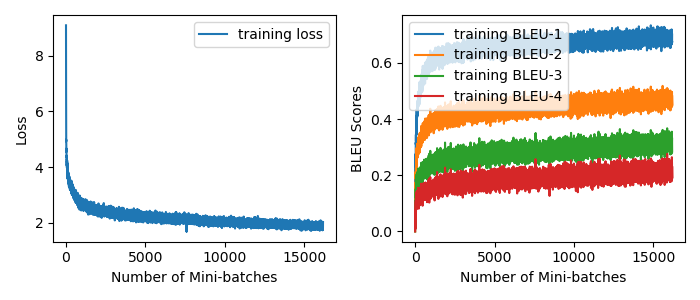

Start/Continue training from epoch 5
Finish training for 5 epochs


In [70]:
fig, axes = plt.subplots(ncols=2, figsize=(7, 3))
exp1.run(num_epochs=5, plot=lambda exp: plot(exp, fig=fig, axes=axes))

In [71]:
# exp1_val = exp1.evaluate()
# print(exp1_val)

In [72]:
with open(op_dir+'val_result.txt','r') as t_file:
    op = t_file.read()
    
print(op)
# Make this format JSON readable
op = op.replace("\'", "\"")

# Convert String to dictionary
op_dict = json.loads(op)

{'loss': 2.356605567814652, 'bleu': [0.6726515753984309, 0.4454975600090082, 0.2827504305186277, 0.18616016251005366]}



In [73]:
print("Validation dataset loss is {:.4f}".format(op_dict['loss']))

Validation dataset loss is 2.3566


In [74]:
print("Validation dataset scores are as follows:- \nBLEU-1: {:.4f}\nBLEU-2: {:.4f}\nBLEU-3: {:.4f}\nBLEU-4: {:.4f}"\
      .format(op_dict['bleu'][0], op_dict['bleu'][1], op_dict['bleu'][2], op_dict['bleu'][3]))

Validation dataset scores are as follows:- 
BLEU-1: 0.6727
BLEU-2: 0.4455
BLEU-3: 0.2828
BLEU-4: 0.1862


### DEMO Starts Here

#### Pick random image

In [75]:
# Seed for reproducability
np.random.seed(37)

# validation dataset
val_rand_id = np.random.randint(0, len(val_dataset))

#### Display the random image

In [76]:
orig_val_img, val_cap = val_dataset.__getitem__(val_rand_id)

<IPython.core.display.Javascript object>


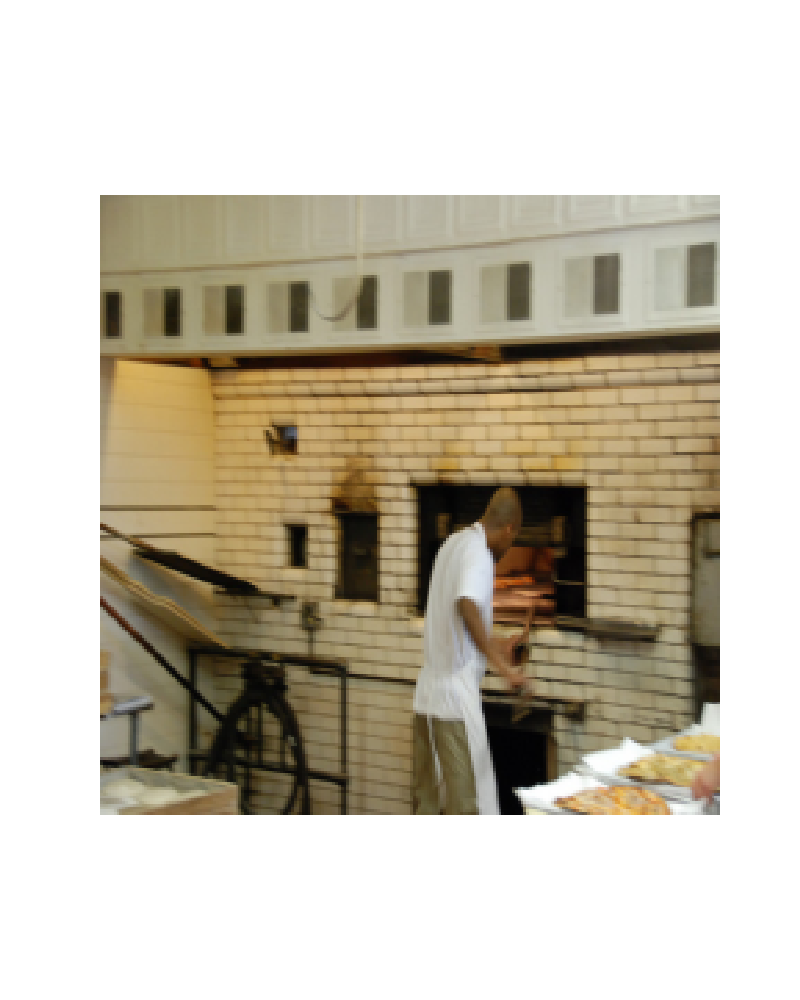

tensor([8.8410e+03, 1.0000e+00, 1.6600e+02, 1.2700e+02, 3.3000e+02, 2.4800e+02,
        1.0600e+02, 2.4500e+02, 1.1000e+01, 1.0000e+00, 3.3200e+02, 1.2350e+03,
        1.7800e+02, 8.8420e+03])
a man is taking some food out of a large brick oven


In [77]:
f = plt.figure()
myimshow(orig_val_img)
print(val_cap)
true_cap = index_to_cap(val_cap)
true_cap_lab = val_cap
print(true_cap)

#### Forward prop the new image through the trained network

In [78]:
cap_len = len(val_cap)
max_cap_len = cap_len
cap_len = torch.Tensor([cap_len])
val_cap = val_cap.type(torch.LongTensor)
with torch.no_grad():
    val_img = orig_val_img.view(1, orig_val_img.size()[0], orig_val_img.size()[1], orig_val_img.size()[2])
    val_cap = val_cap.view(1, val_cap.size()[0])
    x, d, cap_len = val_img.to(exp1.net.device), val_cap.to(exp1.net.device), cap_len.to(exp1.net.device)
    y = exp1.net.forward(x, d, cap_len)
    _, pred_cap_lab = torch.max(y, 1)
    true_cap_lab = d
    pred_cap = index_to_cap(pred_cap_lab)
print("Predicted Caption labels:", pred_cap_lab)
print("Predicted Caption is:\n", pred_cap)
print("True Caption is:\n", true_cap)
print("True Caption Labels:", true_cap_lab)

Predicted Caption labels: tensor([8841,    1,  166,  221,  221,    1,  106,   32,   11,    1,  651,  678,
         178, 8842], device='cuda:0')
Predicted Caption is:
 a man sitting sitting a food from of a box bowl oven
True Caption is:
 a man is taking some food out of a large brick oven
True Caption Labels: tensor([[8841,    1,  166,  127,  330,  248,  106,  245,   11,    1,  332, 1235,
          178, 8842]], device='cuda:0')


#### Horizonatl Flip

In [79]:
transform = tv.transforms.Compose([
    tv.transforms.Resize((224, 224)),
    tv.transforms.RandomHorizontalFlip(p=1.0),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
image = orig_val_img.to('cpu').numpy()
image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
image = (image + 1) / 2
image[image<0] = 0
image[image>1] = 1
image = Image.fromarray(np.uint8((image)*255))
val_img = transform(image)

<IPython.core.display.Javascript object>


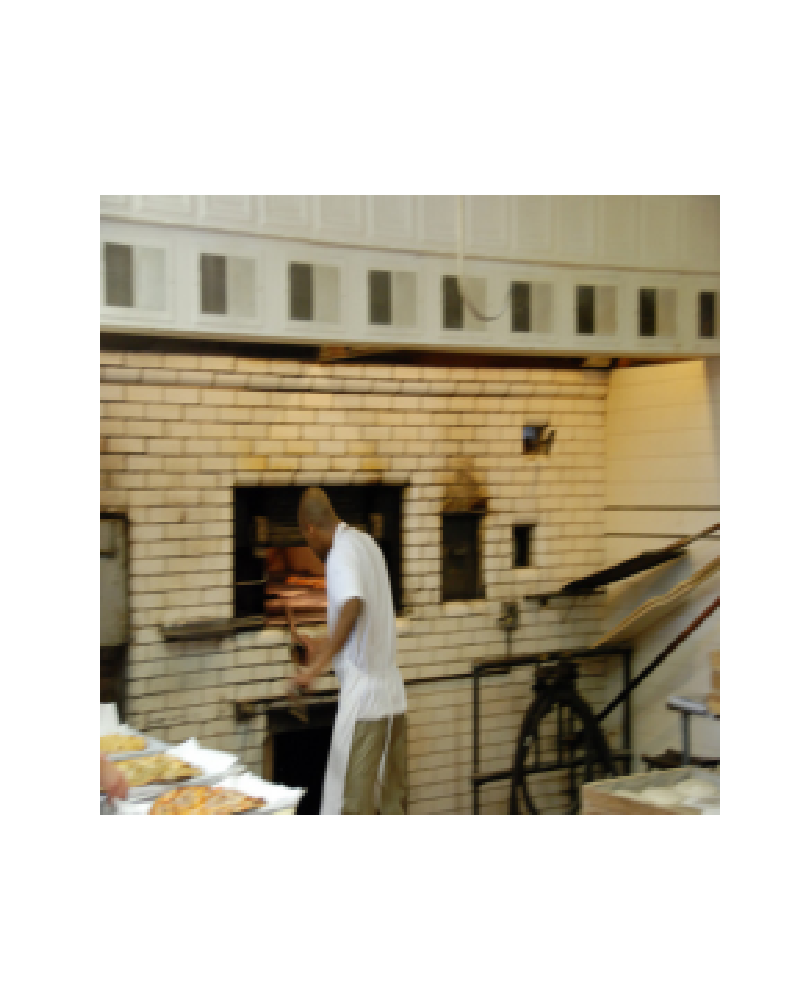

In [80]:
f = plt.figure()
myimshow(val_img)

In [81]:
with torch.no_grad():
    val_img = orig_val_img.view(1, orig_val_img.size()[0], orig_val_img.size()[1], orig_val_img.size()[2])
    x, d, cap_len = val_img.to(exp1.net.device), val_cap.to(exp1.net.device), cap_len.to(exp1.net.device)
    y = exp1.net.forward(x, d, cap_len)
    _, pred_cap_lab = torch.max(y, 1)
    true_cap_lab = d
    pred_cap = index_to_cap(pred_cap_lab)
print("Predicted Caption labels:", pred_cap_lab)
print("Predicted Caption is:\n", pred_cap)
print("True Caption is:\n", true_cap)
print("True Caption Labels:", true_cap_lab)

Predicted Caption labels: tensor([8841,    1,  166,  127,  221,    1,  106,  245,   11,    1,  678,  678,
         178, 8842], device='cuda:0')
Predicted Caption is:
 a man is sitting a food out of a bowl bowl oven
True Caption is:
 a man is taking some food out of a large brick oven
True Caption Labels: tensor([[8841,    1,  166,  127,  330,  248,  106,  245,   11,    1,  332, 1235,
          178, 8842]], device='cuda:0')


#### Vertical Flip

In [82]:
transform = tv.transforms.Compose([
    tv.transforms.Resize((224, 224)),
    tv.transforms.RandomVerticalFlip(p=1.0),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
image = orig_val_img.to('cpu').numpy()
image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
image = (image + 1) / 2
image[image<0] = 0
image[image>1] = 1
image = Image.fromarray(np.uint8((image)*255))
val_img = transform(image)

<IPython.core.display.Javascript object>


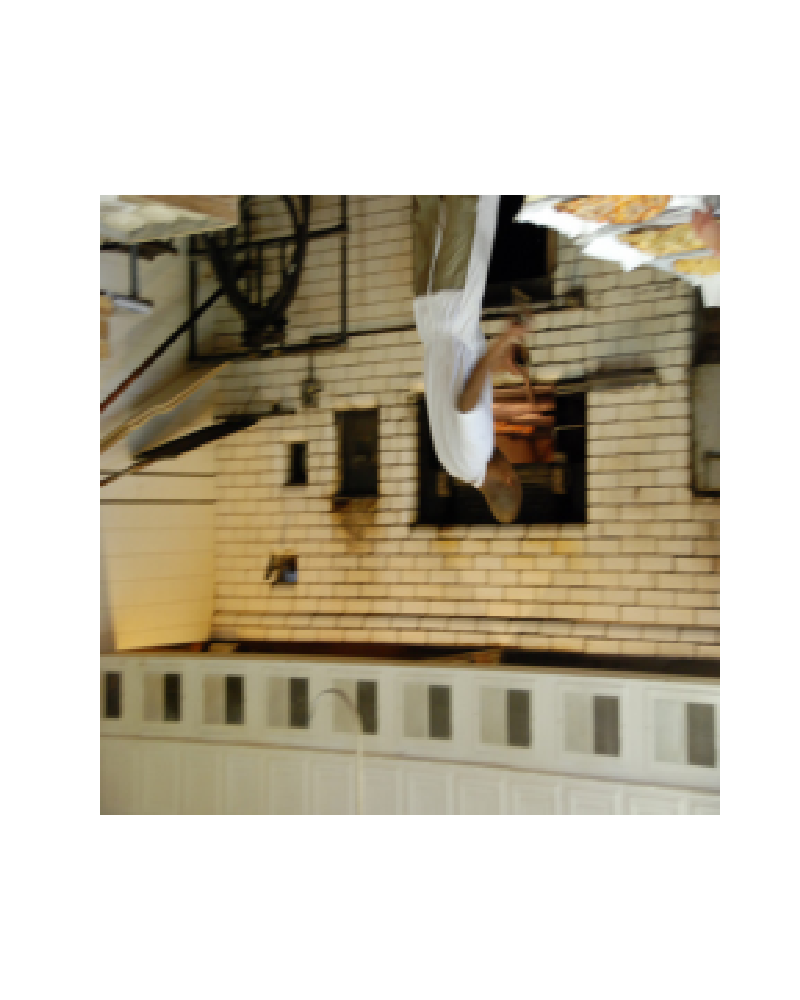

In [83]:
f = plt.figure()
myimshow(val_img)

In [84]:
with torch.no_grad():
    val_img = orig_val_img.view(1, orig_val_img.size()[0], orig_val_img.size()[1], orig_val_img.size()[2])
    x, d, cap_len = val_img.to(exp1.net.device), val_cap.to(exp1.net.device), cap_len.to(exp1.net.device)
    y = exp1.net.forward(x, d, cap_len)
    _, pred_cap_lab = torch.max(y, 1)
    true_cap_lab = d
    pred_cap = index_to_cap(pred_cap_lab)
print("Predicted Caption labels:", pred_cap_lab)
print("Predicted Caption is:\n", pred_cap)
print("True Caption is:\n", true_cap)
print("True Caption Labels:", true_cap_lab)

Predicted Caption labels: tensor([8841,    1,   88,  221,  221,    1,  106,  245,   11,    1,  678,  678,
         178, 8842], device='cuda:0')
Predicted Caption is:
 a woman sitting sitting a food out of a bowl bowl oven
True Caption is:
 a man is taking some food out of a large brick oven
True Caption Labels: tensor([[8841,    1,  166,  127,  330,  248,  106,  245,   11,    1,  332, 1235,
          178, 8842]], device='cuda:0')
